## using yt's stretched grid functionality with zfp-compressed lofs-cm1 netcdf files

yt 4.1.0 includes improved handling of stretched grids (defined as grids with variable spacing in each dimension). Stretched grids are common in geoscience data and so it's useful to demonstrate in the context of the zfp-compressed lofs-cm1 netcdf files (see zfp_cm1_yt_demo.ipynb in this repository). 



In [9]:
import netCDF4 as nc 
import numpy as np
from yt.sample_data.api import lookup_on_disk_data
ds = nc.Dataset(lookup_on_disk_data("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc"))


In [5]:
ds.variables['dbz']

<class 'netCDF4._netCDF4.Variable'>
float32 dbz(time, zh, yh, xh)
    long_name: radar_reflectivity_simulated
    units: dBZ
    zfp_accuracy_netcdf: 4.0
unlimited dimensions: time
current shape = (1, 232, 996, 1096)
filling on, default _FillValue of 9.969209968386869e+36 used

In [13]:
ds.variables['xh']

<class 'netCDF4._netCDF4.Variable'>
float32 xh(xh)
    long_name: x-coordinate in Cartesian system
    units: km
    axis: X
unlimited dimensions: 
current shape = (1096,)
filling on, default _FillValue of 9.969209968386869e+36 used

The data here are vertex-centered data (e.g., `dbz` is defined at the coordinates given by `zh`, `yh` and `zh`) and so to load in as a stretched-grid, we need to account for this. The simplest approach is to calcuate cell-centered values from the vertex values using trilinear interpolation. This will result in a reduction of 1 element in each dimension. 

To do this, we need: 

1. The effective cell widths (given by the difference in the coordinate arrays)
2. The new cell center locations
3. The fractional distance weighting for the location of each cell center relative to the width of each cell

Calculating for a single coordinate is easy:

In [21]:
def get_new_coords(coord):
    
    # the min/max of the range, useful for left/right edge
    extrema = [coord.min(), coord.max()]
    
    wids = (coord[1:] - coord[0:-1]) # width of each cell in this dimensions
    centers = (coord[1:] + coord[0:-1])/2. # center of each cell in this dimension
    wt = (centers - coord[0:-1])/wids  # fractional distance from the starting vertices in this dimension
    
    return extrema, wids.astype("float64"), centers, wt.astype("float64")

And given the weights, we need a method to interpolate data values from the vertices to the new cell centers. Some options here... but for demonstration purposes, can just implement a vectorized version of the standard trilinear interpolation (https://en.wikipedia.org/wiki/Trilinear_interpolation):

In [22]:
def vectorized_trilinear_interp(data_v, wts):
    # vectorized implementation of standard trilinear interp () 
    # data_v : vertex-centered data 
    # wts : the distance-weight along each coordinate for each cell
    
    # interpolate over first dim
    c00 = data_v[0:-1, 0:-1, 0:-1] * (1-wts[0]) + data_v[1:, 0:-1, 0:-1]  * wts[0]
    c01 = data_v[0:-1, 0:-1, 1:] * (1-wts[0]) + data_v[1:, 0:-1, 1:]  * wts[0]
    c10 = data_v[0:-1, 1:, 0:-1] * (1-wts[0]) + data_v[1:, 1:, 0:-1]  * wts[0]
    c11 = data_v[0:-1, 1:, 1:] * (1-wts[0]) + data_v[1:, 1:, 1:]  * wts[0]
    
    # and over second dim
    c0 = c00 * (1 - wts[1]) + c01 * wts[1]
    c1 = c10 * (1 - wts[1]) + c11 * wts[1]

    # and over final dim
    c = c0 * (1 - wts[2]) + c1 * wts[2] 
    
    for idim in range(3):
        assert c.shape[idim] == data_v.shape[idim] - 1
        
    return c 

we're now ready to load into a yt dataset as a stretched grid!

In [23]:
import h5py 
import yt 
import hdf5plugin
from yt.sample_data.api import lookup_on_disk_data
import numpy as np


    
def load_cm1_stretched_in_memory(fn, fields = None):
    """ loads lofs-cm1 data on a single stretched grid """
    
    data_coords = ("zh", "yh", "xh")  # name in the netcdf file 
    yt_coord_name = ("z", "y", "x")  # internal yt name
    
    if fields is None:
        fields = ["dbz", "vortmag"]
        
    # first read in the data and global coordinates
    fn = str(lookup_on_disk_data(fn))
    data = {}    
    global_coord_info = {}  # store the x,y,z widths and ranges across the dataset
    with h5py.File(fn, "r") as handle:
        for dim, ytdim in zip(data_coords, yt_coord_name):
            global_coord_info[ytdim] = get_new_coords(handle[dim][:])  # returns extrema, wids, centers, wt
            
        for field in fields:
            # interpolate the vertex-centered values 
            c_vals = vectorized_trilinear_interp(handle[field][0,:], global_coord_info[ytdim][3])
            data[field] = (c_vals, "")  # neglecting units here 
            
    
    # store the bounding box
    bbox = np.array([global_coord_info[dim][0] for dim in yt_coord_name])
    
    # store the cell widths
    cell_wids = [global_coord_info[dim][1] for dim in yt_coord_name]

    return yt.load_uniform_grid(data, data[fields[0]][0].shape, 
                                length_unit="km", 
                                geometry=("cartesian", yt_coord_name),
                                bbox=bbox, 
                                cell_widths=cell_wids)

In [24]:
%%time
ds = load_cm1_stretched_in_memory("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc")

yt : [INFO     ] 2022-10-06 15:42:41,040 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-10-06 15:42:41,041 Parameters: domain_dimensions         = [ 231  995 1095]
yt : [INFO     ] 2022-10-06 15:42:41,043 Parameters: domain_left_edge          = [  0.0375     -29.88750076 -37.38750076]
yt : [INFO     ] 2022-10-06 15:42:41,044 Parameters: domain_right_edge         = [17.36249924 44.73749924 44.73749924]
yt : [INFO     ] 2022-10-06 15:42:41,046 Parameters: cosmological_simulation   = 0


CPU times: user 11.6 s, sys: 4.54 s, total: 16.2 s
Wall time: 16.2 s


yt : [INFO     ] 2022-10-06 15:42:43,001 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-06 15:42:43,002 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-06 15:42:43,004 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-06 15:42:43,005 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-06 15:42:43,014 Making a fixed resolution buffer of (('stream', 'dbz')) 800 by 800



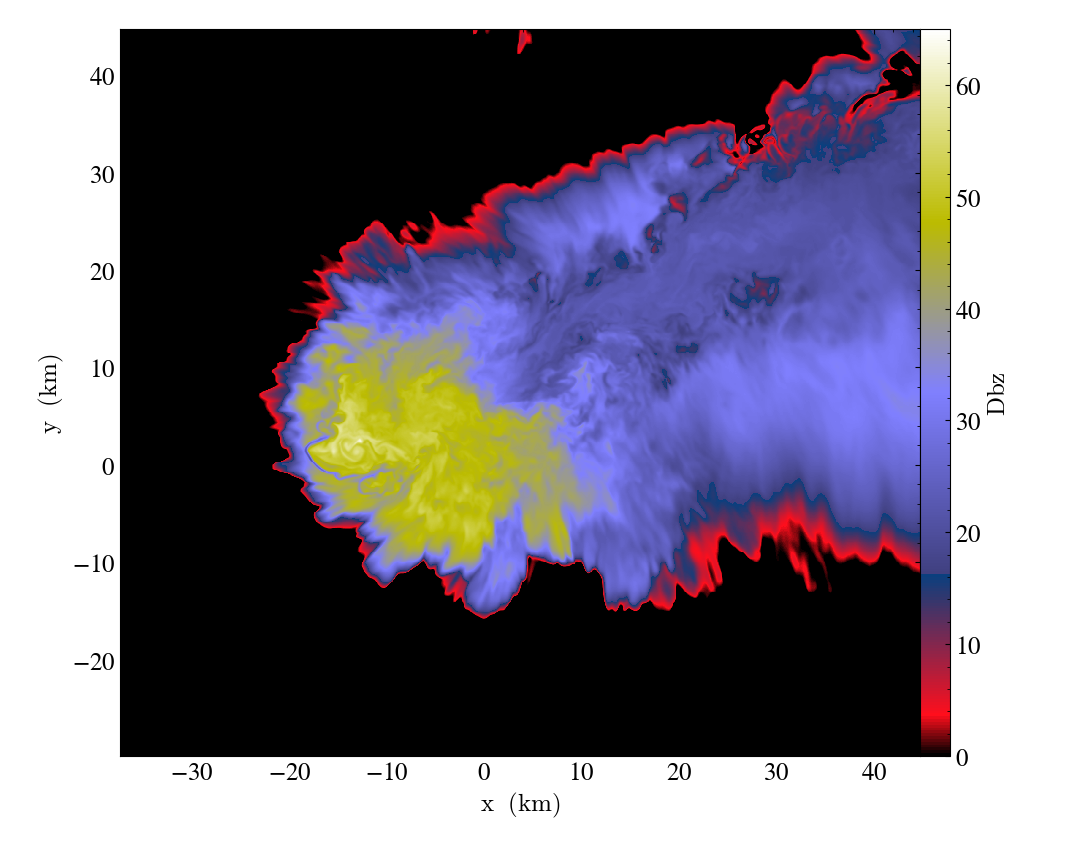

In [25]:
def set_cmap_prefs(yt_plot, field, cmap_name, cmap_limits):
    yt_plot.set_log(field, False)
    yt_plot.set_cmap(field, cmap_name)
    yt_plot.set_zlim(field, cmap_limits[0], cmap_limits[1])
    
field = ("stream", "dbz")
slc = yt.SlicePlot(ds, "z", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()